In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from geopy.distance import great_circle
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectFromModel, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
final_features_csv_file = os.path.join(parent_dir, 'data', 'final_features.csv')
df = pd.read_csv(final_features_csv_file)
print(df.shape)
# df.head(5)
print(df.dtypes)

(1296675, 16)
merchant              object
category              object
amt                  float64
gender                object
city                  object
state                 object
job                   object
trans_num             object
is_fraud               int64
trans_month_sin      float64
trans_month_cos      float64
trans_hour_sin       float64
trans_hour_cos       float64
age                  float64
distance             float64
city_pop_category     object
dtype: object


In [3]:
def preprocess_data():
    # numerical_features = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long','cc_num']
    # categorical_features = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'trans_num']
    numerical_features = ['amt','trans_month_sin', 'trans_month_cos', 'trans_hour_sin', 'trans_hour_cos','age','distance']
    categorical_features = ['merchant', 'category','gender','city','state', 'job','trans_num']
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
    return preprocessor

<h2>SVM classifier</h2>

In [11]:
# Define features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = preprocess_data()


# Create the pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=10))
])


# Train the model
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

here
here 2
here 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.95      0.55      0.69      1520

    accuracy                           1.00    259335
   macro avg       0.97      0.77      0.85    259335
weighted avg       1.00      1.00      1.00    259335



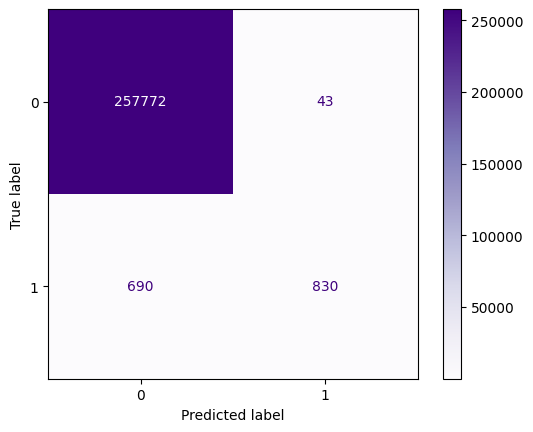

In [12]:
ConfusionMatrixDisplay.from_estimator(clf, X_test,y_test,cmap='Purples')

In [17]:
joblib.dump(clf,'/home/fm-pc-lt-173/fraud_detection/pythonProject/data/svm_default_setup.joblib')

['/home/fm-pc-lt-173/fraud_detection/pythonProject/data/svm_default_setup.joblib']

<h2>Decision Tree</h2>

In [ ]:
# Define features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = preprocess_data()

# Create the pipeline
clf = make_pipeline(
        preprocessor,
        SMOTE(sampling_strategy='minority', random_state=5),
        DecisionTreeClassifier(random_state=10)
    )

# clf = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', DecisionTreeClassifier(random_state=10))
# ])

# Train the model
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

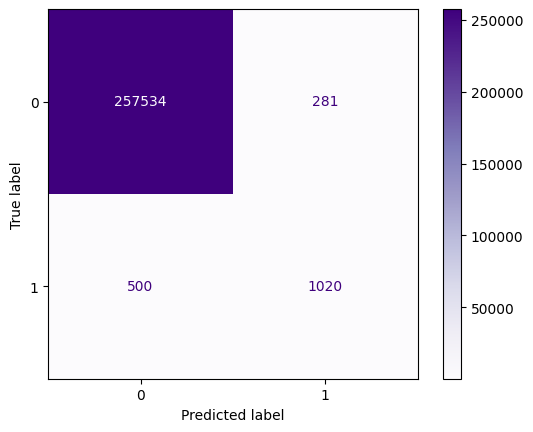

In [21]:
ConfusionMatrixDisplay.from_estimator(clf, X_test,y_test,cmap='Purples')

In [22]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
model_path = os.path.join(parent_dir, 'model', 'july12_final_features_w_smote_decisiontree_default_setup.joblib')
joblib.dump(clf,model_path)

['/Users/rosni/PycharmProjects/client_project/fraud_detection/model/july12_raw_data_decisiontree_default_setup.joblib']

In [23]:
# Get the names of the numerical features
# numerical_features = ['amt','trans_month_sin', 'trans_month_cos', 'trans_hour_sin', 'trans_hour_cos','age','distance']
# categorical_features = ['merchant', 'category','gender','city','state', 'job','trans_num']
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long','cc_num']
categorical_features = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'job', 'trans_num']

# Combine the names
# Get the names of the categorical features after one-hot encoding
categorical_transformer = clf.named_steps['preprocessor'].named_transformers_['cat']
categorical_feature_names = categorical_transformer.get_feature_names_out(categorical_features)

# Combine the names
feature_names = list(numerical_features) + list(categorical_feature_names)

features_path = os.path.join(parent_dir, 'model', 'july12_final_features_w_smote_features_decisiontree_feature_imp.csv')
feature_importances = clf.named_steps['classifier'].feature_importances_
print(len(feature_importances))

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
feature_importances_df.to_csv(features_path)

1042282


<h2>KNN</h2>

In [25]:
# Define features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = preprocess_data()

# Create the pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=10))
])


# Train the model
clf.fit(X_train, y_train)


# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

here
here 2
here 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.88      0.70      0.78      1520

    accuracy                           1.00    259335
   macro avg       0.94      0.85      0.89    259335
weighted avg       1.00      1.00      1.00    259335



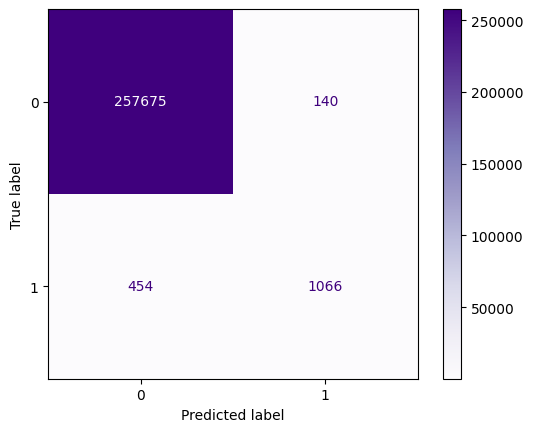

In [26]:
ConfusionMatrixDisplay.from_estimator(clf, X_test,y_test,cmap='Purples')

In [27]:
joblib.dump(clf,'/home/fm-pc-lt-173/fraud_detection/pythonProject/data/knn_default_setup.joblib')

['/home/fm-pc-lt-173/fraud_detection/pythonProject/data/knn_default_setup.joblib']

<h2>Logistic Regression</h2>

In [28]:
# Define features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = preprocess_data()

# Create the pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=10))
])

# Train the model
clf.fit(X_train, y_train)


# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

here
here 2


/home/fm-pc-lt-173/anaconda3/envs/wmcglobal/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


here 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.85      0.23      0.36      1520

    accuracy                           1.00    259335
   macro avg       0.92      0.61      0.68    259335
weighted avg       0.99      1.00      0.99    259335



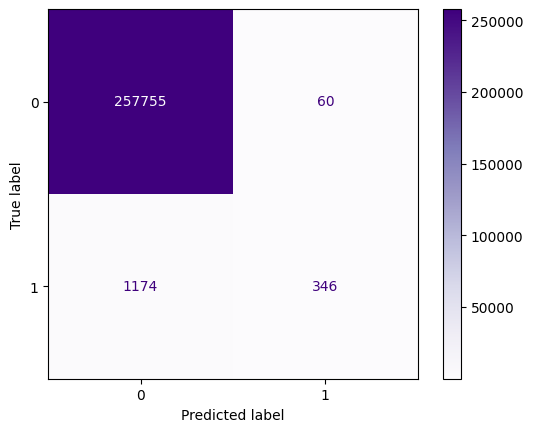

In [29]:
ConfusionMatrixDisplay.from_estimator(clf, X_test,y_test,cmap='Purples')

In [30]:
joblib.dump(clf,'/home/fm-pc-lt-173/fraud_detection/pythonProject/data/logisticregression_default_setup.joblib')

['/home/fm-pc-lt-173/fraud_detection/pythonProject/data/logisticregression_default_setup.joblib']